In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
from tqdm import tqdm
import numpy as np

In [2]:
# Read the list of USGS stations containing width measurements
file_path = '/N/lustre/project/proj-212/abhinav/River_Width_analysis/Dataset/USGS_field_data/width_measurements_stations_raw.csv'
usgs_data = pd.read_csv(file_path)

In [3]:
# Read River line data
base_path = '/N/lustre/project/proj-212/abhinav/River_Width_analysis/Dataset/MERIT_riverlines/'

riverlines_gdfs = []
for i in tqdm(range(7, 9)):
    file_path = f'{base_path}riv_pfaf_{i}_MERIT_Hydro_v07_Basins_v01.shp'
    gdf = gpd.read_file(file_path)
    riverlines_gdfs.append(gdf)

all_region_riverlines_gdf = gpd.GeoDataFrame(pd.concat(riverlines_gdfs, ignore_index=True))

100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.25s/it]


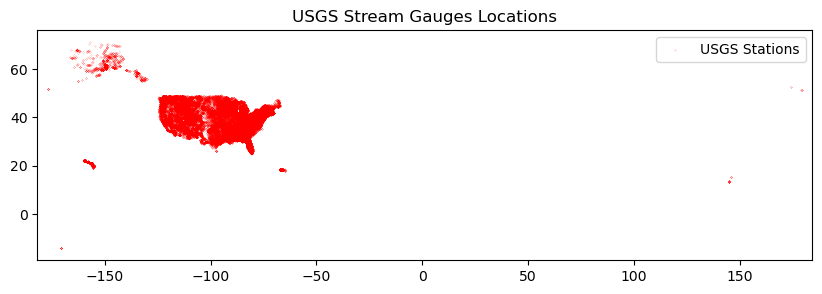

In [4]:
# Plot points on map

filename = os.path.join('/N/lustre/project/proj-212/abhinav/River_Width_analysis/Dataset/US_states_map', 'continental_US.shp')
us_map = gpd.read_file(filename)

# Create a GeoDataFrame for USGS data
geometry = [Point(xy) for xy in zip(usgs_data['dec_long_va'], usgs_data['dec_lat_va'])]
geo_df = gpd.GeoDataFrame(usgs_data, geometry=geometry, crs="EPSG:4269") # EPSG:4269  = NAD83

# Convert USGS points to WGS84 (EPSG:4326) to match base map
geo_df = geo_df.to_crs("EPSG:4326")

# Plotting the world map and the USGS stations
fig, ax = plt.subplots(figsize=(10, 6))
us_map.plot(ax = ax, edgecolor='black')
geo_df.plot(ax=ax, marker='o', color='red', markersize=0.01, label="USGS Stations")

# Zoom to extent of data with some padding
minx, miny, maxx, maxy = geo_df.total_bounds
ax.set_xlim(minx - 5, maxx + 5)
ax.set_ylim(miny - 5, maxy + 5)

# Adding a title and showing the plot
plt.title('USGS Stream Gauges Locations')
plt.legend()
plt.show()


In [5]:
all_region_riverlines_gdf = all_region_riverlines_gdf.set_crs(epsg=4326, allow_override=True)

geo_df_projected = geo_df.to_crs(epsg=3857)
all_region_riverlines_gdf_projected = all_region_riverlines_gdf.to_crs(epsg=3857)

In [6]:
# Compute the intersection between river lines and USGS points
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm

# Function to use spatial index for efficient nearest neighbor search with buffer
def find_nearest_comid_with_spatial_index(point, riverlines_gdf, buffer_size):
    # Buffer the point slightly to increase the chance of finding nearby riverlines
    point_buffer = point.buffer(buffer_size)
    
    # Create a spatial index for riverlines
    spatial_index = riverlines_gdf.sindex
    
    # Find potential matches within the bounding box using 'intersection' method
    possible_matches_index = list(spatial_index.intersection(point_buffer.bounds))
    possible_matches = riverlines_gdf.iloc[possible_matches_index]
    
    # If there are no possible matches, return None
    if possible_matches.empty:
        return None
    
    # Compute the actual distance to these potential matches
    distances = possible_matches.geometry.distance(point)
    
    # Get the index of the minimum distance
    nearest_idx = distances.idxmin()
    
    # Return the COMID of the nearest riverline
    return riverlines_gdf.loc[nearest_idx, 'COMID']

# Multiprocessing with tqdm and spatial index optimization
def parallel_apply_nearest_comid_with_spatial_index(geo_df, riverlines_gdf, buffer_size=0.001):
    # Use tqdm for progress tracking
    tqdm.pandas(desc="Processing Points")
    
    # Apply the nearest COMID function with spatial index optimization and buffer
    return geo_df.geometry.progress_apply(find_nearest_comid_with_spatial_index, riverlines_gdf=riverlines_gdf, buffer_size=buffer_size)

# Ensure both datasets have the same CRS
geo_df_projected = geo_df_projected.to_crs(all_region_riverlines_gdf_projected.crs)

buffer_size_meters = 10  # buffer size in meters

geo_df_projected['nearest_COMID'] = parallel_apply_nearest_comid_with_spatial_index(
    geo_df_projected, 
    all_region_riverlines_gdf_projected, 
    buffer_size=buffer_size_meters
)

Processing Points: 100%|██████████████████████████████████████████████| 73783/73783 [00:34<00:00, 2128.74it/s]


In [7]:
geo_df_projected

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,coord_datum_cd,dec_coord_datum_cd,geometry,nearest_COMID
0,USGS,1.010000e+06,"St. John River at Ninemile Bridge, Maine",ST,46.700556,-69.715556,S,NAD83,NAD83,POINT (-7760699.726 5893333.324),72041835.0
1,USGS,1.010070e+06,"Big Black River near Depot Mtn, Maine",ST,46.893889,-69.751667,S,NAD83,NAD83,POINT (-7764719.601 5924771.17),72042430.0
2,USGS,1.010500e+06,"St. John River at Dickey, Maine",ST,47.113056,-69.088056,S,NAD83,NAD83,POINT (-7690846.895 5960547.565),72039834.0
3,USGS,1.011000e+06,"Allagash River near Allagash, Maine",ST,47.069722,-69.079444,S,NAD83,NAD83,POINT (-7689888.283 5953462.347),72039840.0
4,USGS,1.012790e+06,Unnamed trib to N. Fork McLean B nr St. Agatha...,ST,47.225500,-68.340111,5,NAD83,NAD83,POINT (-7607586.224 5978959.466),NaN
...,...,...,...,...,...,...,...,...,...,...,...
73778,USGS,6.952250e+14,KATAKTURUK R NR KAKTOVIK AK,ST,69.873397,-145.202805,U,NAD27,NAD83,POINT (-16163902.292 11027633.938),81001134.0
73779,USGS,7.004380e+14,CANNING R DELTA E CHANNEL NR KAKTOVIK AK,ST,70.077012,-145.712584,U,NAD27,NAD83,POINT (-16220650.653 11093827.716),81000677.0
73780,USGS,8.816000e+07,IDWSC Standalone Calibrations,ST,43.617667,-116.184283,F,NAD27,NAD83,POINT (-12933575.335 5406464.66),78025643.0
73781,USGS,8.825000e+07,Test Station No. 1 for Mass,ST,42.343333,-71.624722,S,NAD83,NAD83,POINT (-7973227.728 5212548.649),73003532.0


In [8]:
# Remove nan rows
geo_df_projected = geo_df_projected[~geo_df_projected['nearest_COMID'].isna()]

In [9]:
geo_df_projected['site_no'].unique().shape

(50868,)

## Read GLOW-S data

In [10]:
# File paths for the parquet files
file_path_7_large = "/N/lustre/project/proj-212/abhinav/River_Width_analysis/RiverWidthAnalysis/GLOW-S_regions_merged/GLOW-S_region_7_daywidth.parquet"
file_path_8_large = "/N/lustre/project/proj-212/abhinav/River_Width_analysis/RiverWidthAnalysis/GLOW-S_regions_merged/GLOW-S_region_8_daywidth.parquet"

# Load the parquet files into DataFrames
df_7_large = pd.read_parquet(file_path_7_large)
df_8_large = pd.read_parquet(file_path_8_large)

# Concatenate the two DataFrames
df_78_large = pd.concat([df_7_large, df_8_large], ignore_index=True)

# Add a new field'riverID'
df_78_large['riverID'] = df_78_large['crossSxnID']
df_78_large = df_78_large.drop(columns=['crossSxnID'])

# Read cross-section lat longs
file_path_7_xs = "/N/lustre/project/proj-212/abhinav/River_Width_analysis/RiverWidthAnalysis/GLOW-S_crosssection_points/GLOW-S_region_7.shp"
file_path_8_xs = "/N/lustre/project/proj-212/abhinav/River_Width_analysis/RiverWidthAnalysis/GLOW-S_crosssection_points/GLOW-S_region_8.shp"

# Load cross-section data
df_7_xs = gpd.read_file(file_path_7_xs)
df_8_xs = gpd.read_file(file_path_8_xs)
df_78_xs = pd.concat([df_7_xs, df_8_xs], ignore_index=True)

# Merge two datasets
combined_df_78 = pd.merge(df_78_large, df_78_xs, on='riverID')

df_XS_info = combined_df_78.groupby('riverID').agg(
    count_of_dates=('date', 'count'),
    lat=('lat', 'first'),
    lon=('lon', 'first')
).reset_index()

df_XS_info['COMID'] = df_XS_info['riverID'].str[1:9]
df_XS_info_top = df_XS_info.groupby('COMID').apply(lambda x: x.nlargest(20, 'count_of_dates')).reset_index(drop=True)
df_XS_info_top['COMID'] = df_XS_info_top['COMID'].astype('int64')

/tmp/ipykernel_3349630/2247398557.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_XS_info_top = df_XS_info.groupby('COMID').apply(lambda x: x.nlargest(20, 'count_of_dates')).reset_index(drop=True)


In [11]:
combined_df_78['date'] = pd.to_datetime(combined_df_78['date'])

In [12]:
combined_df_78['COMID'] = combined_df_78['riverID'].str[1:9]

## Read Field width data

In [13]:
direc  = '/N/lustre/project/proj-212/abhinav/River_Width_analysis/Dataset/USGS_field_data'
fname = 'discharge_stage_width_measurements.csv'
df_field = pd.read_csv(os.path.join(direc, fname))

# Convert width values from ft to m and discharge values from cfs to cms
df_field['discharge_va'] = df_field['discharge_va']*0.0283168
df_field['chan_width'] = df_field['chan_width']*0.3048

/tmp/ipykernel_3349630/2787544250.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_field = pd.read_csv(os.path.join(direc, fname))


In [14]:
df_field['site_no'].unique().shape

(14589,)

In [15]:
geo_df = geo_df_projected[['site_no', 'nearest_COMID', 'dec_lat_va', 'dec_long_va']]
df_field_station  = pd.merge(df_field, geo_df, on = 'site_no', how='inner')

In [16]:
df_field_station['site_no'].unique().shape

(12279,)

In [17]:
df_field_station['nearest_COMID']  = df_field_station['nearest_COMID'].astype('int').astype('str')

In [18]:
def parse_to_date(date_str):
    for fmt in ("%m/%d/%Y %H:%M", "%m/%d/%Y"):
        try:
            return pd.to_datetime(date_str, format=fmt).date()
        except ValueError:
            continue
    return pd.NaT  # return NaT if parsing fails

df_field_station['date'] = df_field_station['measurement_dt'].apply(parse_to_date)



In [19]:
df_field_station['date'] = pd.to_datetime(df_field_station['date'])

In [20]:
# Combine field and GLOW-S dataframes
df_field_glows = pd.merge(combined_df_78, df_field_station, 
                          left_on = ['COMID', 'date'],
                         right_on = ['nearest_COMID', 'date'])


In [99]:
df_field_glows[df_field_glows['COMID']=='73005654'][['date', 'width', 'chan_width']]

,date,width,chan_width
38513,2019-04-01,375.545018,6.52272
38514,2019-09-03,342.267048,4.26720
38515,2020-07-21,338.042421,356.61600
38516,2020-11-18,351.813522,4.51104
38517,2021-06-16,375.761834,362.71200
38518,2021-06-29,366.294203,13.71600
38519,2022-06-06,352.542812,15.45336
38520,2022-08-04,343.627076,59.13120
38521,2022-08-04,343.627076,202.69200
38522,2022-11-08,372.772402,13.41120


In [100]:
# Function to compute Havesine distance
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert lat/lon to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 6371 # Earth's radius in kilometers
    return c * r*1000 # distance in meters

In [23]:
dist = []
for _, geo_row in tqdm(df_field_glows.iterrows(), total=len(df_field_glows)):
    lat1, lon1 = geo_row['lat'], geo_row['lon']
    lat2, lon2 = geo_row['dec_lat_va'], geo_row['dec_long_va']
    dist.append(haversine_vectorized(lat1, lon1, lat2, lon2))

df_field_glows['USGS_CS_dist_meters'] = dist

100%|██████████████████████████████████████████████████████████████| 377192/377192 [00:24<00:00, 15393.38it/s]


In [24]:
def filteredComidTo60pcMedian(one_comid):
    one_comid_copy = one_comid.copy()
    min_data_taken_from_high_freq_stn =1
    dist_thresh = 500

    # Make proper date format
    one_comid_copy['date'] = pd.to_datetime(one_comid_copy['date'])
    base_date = pd.to_datetime('2000-01-01')
    one_comid_copy['days2000'] = (one_comid_copy['date'] - base_date).dt.days
    one_comid_copy.drop('date', axis=1, inplace=True)
    one_comid_copy = one_comid_copy[one_comid_copy['USGS_CS_dist_meters']<dist_thresh]
    
    # Limit the data by taking 60% data from top n frequent COMID
    river_id_counts = one_comid_copy['riverID'].value_counts()
    cumulative_sum = river_id_counts.cumsum()
    total_sum = river_id_counts.sum()
    threshold = min_data_taken_from_high_freq_stn * total_sum
    filtered_data = one_comid_copy[one_comid_copy['riverID'].isin(river_id_counts.index[0:cumulative_sum[cumulative_sum < threshold].count() + 1])]
    
    # Limit the data to 2% and 98% quantile width_norm
    #quantile_bot = filtered_data['width'].quantile(0.02)
    #quantile_top = filtered_data['width'].quantile(0.98)
    #filtered_data = filtered_data[(filtered_data['width'] > quantile_bot) & (filtered_data['width'] < quantile_top)]
    
    # Median data computation
    median_days2000 = filtered_data.groupby('days2000').filter(lambda x: len(x) >= 4).groupby('days2000')['width'].median()
    sd_days2000 = filtered_data.groupby('days2000').filter(lambda x: len(x) >= 4).groupby('days2000')['width'].std()
    return median_days2000, sd_days2000

In [25]:
# Compute median width for GLOW-S data each COMID

from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Your function to process a single COMID
def process_comid(comid):
    df_tmp = df_field_glows[df_field_glows['COMID'] == comid]
    median_days2000, sd_days2000 = filteredComidTo60pcMedian(df_tmp)

    # Convert indices into date
    date = pd.Timestamp("2000-01-01") + pd.to_timedelta(median_days2000.index, unit='D')
    widths_tmp = median_days2000.values
    sd_width_tmp = sd_days2000.values

    df_median = pd.DataFrame({'date': date, 'width_median': widths_tmp, 'width_cv': sd_width_tmp/widths_tmp})

    # Merge and return
    df_tmp = pd.merge(df_tmp, df_median, on='date', how='right')

    # Remove rows with duplicate dates
    df_tmp = df_tmp.drop_duplicates(subset='date', keep='first')
    
    return df_tmp

# List of COMIDs that matched with USGS in-situ data
comid_list = df_field_glows['COMID'].unique()

bar_format = '{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]'
with Pool(processes=50) as pool:
    results = list(tqdm(pool.imap(process_comid, comid_list), total=len(comid_list), bar_format=bar_format, dynamic_ncols=False))
    
# Combine all non-empty results
df_cat = pd.concat([df for df in results if not df.empty], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████| 3752/3752 [00:06<00:00, 568.61it/s]


In [26]:
df_cat[['COMID', 'riverID', 'date', 'width', 'width_median', 'width_cv', 'chan_width', 'dec_lat_va', 'dec_long_va', 'lat', 'lon']].head(10)

,COMID,riverID,date,width,width_median,width_cv,chan_width,dec_lat_va,dec_long_va,lat,lon
0,71043791,R71043791XS0510887,2019-12-03,294.046427,310.266161,0.060364,NaN,48.996408,-100.958489,48.993050,-100.957784
1,71043891,R71043891XS1544257,2022-03-31,55.071438,65.793915,0.287409,25.32888,48.913328,-97.917037,48.937500,-97.868450
2,71044084,R71044084XS1552360,2019-09-05,13.284211,16.431592,0.505226,16.03248,48.852778,-113.416944,48.895718,-113.418449
3,71044434,R71044434XS0515473,2019-09-05,8.586457,330.382646,0.165892,22.55520,48.798833,-113.656731,48.836425,-113.473575
4,71044984,R71044984XS1585176,2019-07-12,85.965781,48.979587,0.796769,92.35440,48.572206,-97.147570,48.594197,-97.152530
5,71044984,R71044984XS1585176,2019-08-01,93.189962,87.152831,0.023380,93.87840,48.572206,-97.147570,48.594197,-97.152530
6,71044984,R71044984XS1585179,2020-04-15,385.816476,203.800569,0.195976,NaN,48.572206,-97.147570,48.594167,-97.144427
7,71044984,R71044984XS1585179,2020-04-30,355.675078,231.787902,0.272427,229.81920,48.572206,-97.147570,48.594167,-97.144427
8,71044984,R71044984XS1585176,2020-05-12,103.535622,97.418857,0.020196,128.93040,48.572206,-97.147570,48.594197,-97.152530
9,71044993,R71044993XS0519114,2019-04-25,238.565491,215.717877,0.348257,281.63520,48.634428,-93.913311,48.641715,-94.038382


In [27]:
df_cat

,date,width,riverID,lat,lon,geometry,COMID,agency_cd,site_no,measurement_nu,...,horz_vel_desc,vert_vel_desc,chan_loc_cd,chan_loc_dist,nearest_COMID,dec_lat_va,dec_long_va,USGS_CS_dist_meters,width_median,width_cv
0,2019-12-03,294.046427,R71043791XS0510887,48.993050,-100.957784,POINT (-100.95778 48.99305),71043791,USGS,5124000.0,1437,...,EVEN,UNKN,UPST,15.0,71043791,48.996408,-100.958489,376.959051,310.266161,0.060364
1,2022-03-31,55.071438,R71043891XS1544257,48.937500,-97.868450,POINT (-97.86845 48.9375),71043891,USGS,5099600.0,1066,...,EVEN,UNSP,UPST,100.0,71043891,48.913328,-97.917037,4452.490336,65.793915,0.287409
2,2019-09-05,13.284211,R71044084XS1552360,48.895718,-113.418449,POINT (-113.41845 48.89572),71044084,USGS,5018000.0,190,...,EVEN,UNFM,UPST,20.0,71044084,48.852778,-113.416944,4775.971435,16.431592,0.505226
3,2019-09-05,8.586457,R71044434XS0515473,48.836425,-113.473575,POINT (-113.47358 48.83642),71044434,USGS,5014500.0,385,...,UNEV,NSTD,DNST,40.0,71044434,48.798833,-113.656731,14046.450730,330.382646,0.165892
4,2019-07-12,85.965781,R71044984XS1585176,48.594197,-97.152530,POINT (-97.15253 48.5942),71044984,USGS,5092000.0,1278,...,EVEN,STND,UPST,1600.0,71044984,48.572206,-97.147570,2472.295440,48.979587,0.796769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,2020-08-21,8.764348,R81034272XS1306211,59.747791,-153.866958,POINT (-153.86696 59.74779),81034272,USGS,15300300.0,138,...,UNSP,UNSP,ATGA,0.0,81034272,59.757950,-153.846887,1593.704425,26.936527,0.391635
3440,2020-05-05,37.267815,R81034469XS1311842,59.585481,-139.493814,POINT (-139.49381 59.58548),81034469,USGS,15129500.0,214,...,EVEN,STND,UPST,250.0,81034469,59.586366,-139.494188,100.666024,29.397662,0.642117
3441,2019-10-07,467.882667,R81034960XS1327741,59.189167,-138.380362,POINT (-138.38036 59.18917),81034960,USGS,15129120.0,37,...,EVEN,STND,DNST,2500.0,81034960,59.192806,-138.333917,2675.896331,291.903808,0.140230
3442,2020-05-05,1862.582274,R81034960XS1327747,59.189167,-138.361714,POINT (-138.36171 59.18917),81034960,USGS,15129120.0,39,...,UNEV,UNKN,DNST,500.0,81034960,59.192806,-138.333917,1633.972628,395.590004,0.731968


## Read lake data

In [28]:
# Load the shapefile
hydrolakes = gpd.read_file("ClimateRegionDivision/HUC_Parquet/HydroLakes/HydroLAKES.shp")

In [29]:
# Compute the distance of USGS stations from nearest lake
lat_hydrolakes = hydrolakes['Pour_lat'].values
lon_hydrolakes = hydrolakes['Pour_long'].values

lake_field_dist = []
for ii in tqdm(range(df_cat.shape[0])):
    df_coord = df_cat.iloc[ii][['dec_lat_va', 'dec_long_va']]
    lat, lon = df_coord['dec_lat_va'], df_coord['dec_long_va']
    dist = haversine_vectorized(lat, lon, lat_hydrolakes, lon_hydrolakes)
    dist_min = np.min(dist)
    lake_field_dist.append(dist_min)
df_cat['lake_dist_meter'] = lake_field_dist

100%|█████████████████████████████████████████████████████████████████████| 3444/3444 [04:33<00:00, 12.62it/s]


In [75]:
df_cat['COMID'].unique().shape

(1293,)

## Perform validation

In [31]:
import sklearn

# Compute performance metrics
def computePerform(obs, pred):
    mse = np.mean((obs - pred)**2)
    R2 = np.corrcoef(obs, pred)[0, 1]**2

    sse = np.sum((obs - pred)**2)
    sst = np.sum((obs - np.mean(obs))**2)
    nse = 1 - sse/sst
    return mse, R2, nse

df_cat = df_cat.dropna(subset=['chan_width', 'width_median'])

gof, obs_avg, pred_avg, pred_avg_1, comid_avg = [], [], [], [], []
for comid in df_cat['COMID'].unique():
    
    df_part = df_cat[df_cat['COMID'] == comid]
    obs, pred, pred_1 = df_part['chan_width'].values, df_part['width_median'].values, df_part['width'].values
    lat, lon = df_part['dec_lat_va'].values[0], df_part['dec_long_va'].values[0]
    
    if ((obs.shape[0]>5) & (pred.shape[0]>5)):
        mse, r2, nse = computePerform(obs, pred)
        model = sklearn.linear_model.LinearRegression()
        model.fit(obs.reshape(-1, 1), pred.reshape(-1, 1))
        r2 = model.score(obs.reshape(-1, 1), pred.reshape(-1, 1))
        gof.append([comid, mse, r2, nse, obs.shape[0], lat, lon])
        obs_avg.append(np.mean(obs))
        pred_avg.append(np.mean(pred))
        pred_avg_1.append(np.mean(pred_1))
        comid_avg.append(comid)

comid_avg = np.array(comid_avg)
gof = pd.DataFrame(gof, columns=['COMID', 'MSE', 'R2', 'NSE', 'num_obs', 'lat', 'lon'])

Text(0, 0.5, 'Average GLOW-S width (m)')

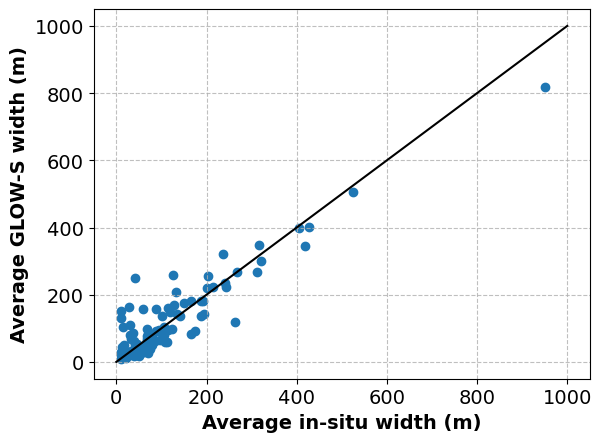

In [32]:
# Plot average in-situ and GLOW-S average values
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'sans-serif'

plt.scatter(obs_avg, pred_avg)
plt.plot([0, 1000], [0, 1000], color='black')
plt.grid(linestyle='--', alpha=0.8)
plt.xlabel('Average in-situ width (m)', fontweight = 'bold')
plt.ylabel('Average GLOW-S width (m)', fontweight = 'bold')

In [33]:
len(comid_avg)

112

In [34]:
df_cat[df_cat['COMID'] == '73021717'][['date', 'width', 'width_median', 'chan_width', 'dec_lat_va', 'dec_long_va', 'width_cv']]

,date,width,width_median,chan_width,dec_lat_va,dec_long_va,width_cv
682,2019-10-01,146.900873,190.312490,172.51680,28.906389,-82.623889,0.424971
683,2019-12-03,121.376739,193.057938,170.99280,28.906389,-82.623889,0.465657
684,2021-04-13,150.190042,160.739015,153.31440,28.905003,-82.635188,0.549960
685,2021-10-20,156.899947,164.087881,188.97600,28.905003,-82.635188,0.545086
686,2021-12-02,153.341066,369.493279,32.61360,28.894702,-82.593157,0.000000
687,2022-02-02,147.716587,218.333649,28.89504,28.894702,-82.593157,0.000000
688,2022-12-07,152.416809,157.390148,181.05120,28.905003,-82.635188,0.564294


In [35]:
# 

Text(50, 800, 'R$^2$ = 0.83')

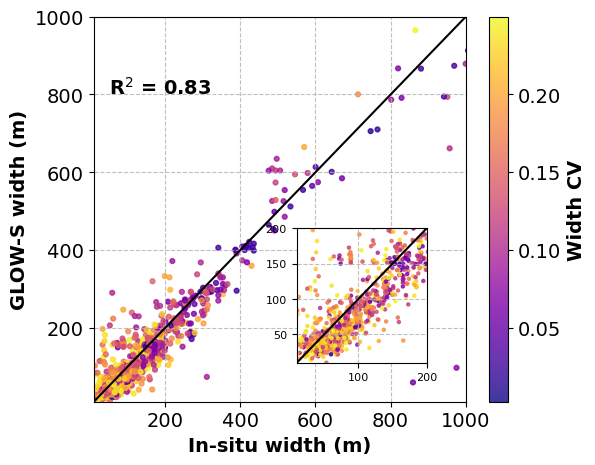

In [95]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_tmp = df_cat.copy()
df_tmp = df_tmp[(df_tmp['width_cv']<0.25) & (df_tmp['width_cv']>0.00) & (df_tmp['lake_dist_meter']>3000)]
obs_w, pred_w, comid_plot = df_tmp['chan_width'].values, df_tmp['width_median'].values, df_tmp['COMID'].values
width_cv = df_tmp['width_cv'].values 

inds = np.nonzero((obs_w>10) & (pred_w>10))[0]
obs_w, pred_w, comid_plot, width_cv = obs_w[inds], pred_w[inds], comid_plot[inds], width_cv[inds]

# Plot
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(obs_w, pred_w, c = width_cv, s=12, cmap = 'plasma', alpha = 0.8)
ax.plot([10, 1000], [10, 1000], color = 'black')
ax.set_xlim(10, 1000)
ax.set_ylim(10, 1000)
ax.set_xlabel('In-situ width (m)', fontweight = 'bold')
ax.set_ylabel('GLOW-S width (m)', fontweight = 'bold')
ax.grid(linestyle='--', alpha=0.8)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Width CV', fontweight='bold')

# inset plot
ax_inset = inset_axes(ax, width="35%", height="35%", loc='lower right', borderpad=2)
ax_inset.scatter(obs_w, pred_w, c=width_cv,  s=5, cmap = 'plasma', alpha = 0.8)
ax_inset.plot([0, 200], [0, 200], color='black')
ax_inset.set_xlim(10, 200)
ax_inset.set_ylim(10, 200)
ax_inset.tick_params(labelsize=8)
ax_inset.grid(linestyle='--', alpha=0.8)

R2 = np.corrcoef(obs_w, pred_w)[0,1]**2
ax.text(50, 800, 'R$^2$ = {}'.format(round(R2, 2)), fontweight='bold')

#plt.savefig('/N/lustre/project/proj-212/abhinav/River_Width_analysis/RiverWidthAnalysis/Final_Figures/insitu_width_validation.tiff', dpi=300)

In [77]:
df_tmp.shape

(1019, 46)

In [67]:
len(inds)

496

(24.5, 49.5)

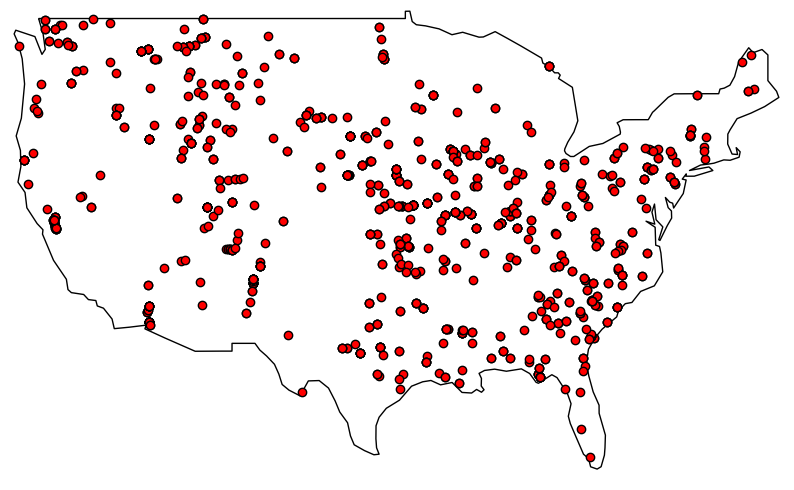

In [73]:
# Plot locations of points
world = gpd.read_file('/N/lustre/project/proj-212/abhinav/River_Width_analysis/RiverWidthAnalysis/Final_Figures/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
usa = world[world['NAME'] == "United States of America"]

df_tmp = df_cat.copy()
df_tmp = df_tmp[(df_tmp['width_cv']<0.25) & (df_tmp['width_cv']>0.00) & (df_tmp['lake_dist_meter']>3000)]
df_tmp['geometry'] = df_tmp.apply(lambda row: Point(row['dec_long_va'], row['dec_lat_va']), axis=1)
gdf = gpd.GeoDataFrame(df_tmp, geometry='geometry', crs='EPSG:4326')  # WGS 84

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(10, 10))
usa.plot(ax=ax, color='None', edgecolor='black')
gdf.plot(ax=ax, color='red', edgecolor='black', alpha=1)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

conus_bounds = (-125, 24.5, -66.5, 49.5)  # (minx, miny, maxx, maxy)
ax.set_xlim(conus_bounds[0], conus_bounds[2])
ax.set_ylim(conus_bounds[1], conus_bounds[3])

#ax.legend(['519 In-situ data locations', 'Selected locations'], frameon = False, loc = 'lower left', bbox_to_anchor=(-0.65, 0.5), prop = {'weight': 'bold', 'size':20})

(51.2, 71.5)

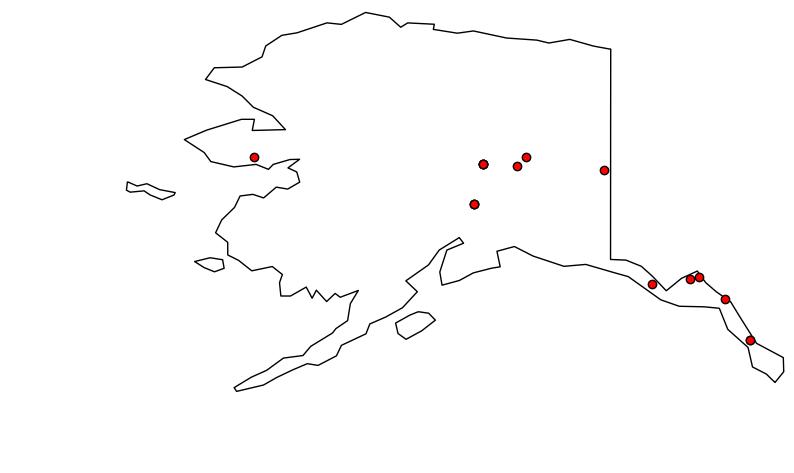

In [74]:
# Plot locations of points
world = gpd.read_file('/N/lustre/project/proj-212/abhinav/River_Width_analysis/RiverWidthAnalysis/Final_Figures/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
usa = world[world['NAME'] == "United States of America"]

df_tmp = df_cat.copy()
df_tmp = df_tmp[(df_tmp['width_cv']<0.25) & (df_tmp['width_cv']>0.00) & (df_tmp['lake_dist_meter']>3000)]
df_tmp['geometry'] = df_tmp.apply(lambda row: Point(row['dec_long_va'], row['dec_lat_va']), axis=1)
gdf = gpd.GeoDataFrame(df_tmp, geometry='geometry', crs='EPSG:4326')  # WGS 84

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(10, 10))
usa.plot(ax=ax, color='None', edgecolor='black')
gdf.plot(ax=ax, color='red', edgecolor='black', alpha=1)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

alaska_bounds = (-179.2, 51.2, -129.9, 71.5)  # (minx, miny, maxx, maxy)
ax.set_xlim(alaska_bounds[0], alaska_bounds[2])
ax.set_ylim(alaska_bounds[1], alaska_bounds[3])

#ax.legend(['519 In-situ data locations', 'Selected locations'], frameon = False)

In [103]:
dif = np.abs(obs_w - pred_w)
ind = np.nonzero((obs_w>800) & (pred_w<200))[0]
comid_plot[ind]

array(['73022244', '74058570'], dtype=object)

In [105]:
df_cat[df_cat['COMID']=='74058570'][['date', 'width', 'width_median', 'chan_width', 'width_cv', 'dec_lat_va', 'dec_long_va']]

,date,width,width_median,chan_width,width_cv,dec_lat_va,dec_long_va
1952,2019-11-05,101.710013,59.778288,109.1184,0.396604,35.765556,-91.300278
1953,2021-05-05,113.108492,97.288971,975.3600,0.070274,35.765556,-91.300278


In [43]:
# 77008673 - near a lake
# 77006057 - near a lake
# 74029699 - near a lake
# 73021538 - near a lake
# 71044434 - in a lake
# 73005836 - near a lake
# 73021717- check width_cv=0.00 for some days
# 74034392- near seevral ponds
# 77013435 - near a lake
# 78024992 - near a lake
# 74050639 - near an island

# 73021494 -  near a reservoir
# 73021555 - check width_cv=0.00 for some days
# 77013512 - near a lake

In [44]:
# 73013093 - GLOW-S seems to be better
# 73021555 - large variation in width
# 73021717 - large variation in width
# 74013947 - Not very large variation in width ()
# 74022461 - GLOW-S seems to be better (Large variation in widths)
### 74028911 - large variation, island
# 74028914 - islands
# 74043226  - near a lake
# 75006901 - near a lake
# 77001527- between two lakes
# 77003232 - near a lake
# 77006057 - near a lake
# 77008673 - near a lake
# 77011277 - near a lake
# 77012495 - near a lake
# 77013435 - near a lake
# 77013512 - not clear why this large difference
# 77013546 - not clear why this large difference
# 77017326 - near a lake
# 78022527 - near a reservoir